In [224]:
import pandas as pd

url = "https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/datasets/vgames2.csv"

df = pd.read_csv(url, index_col = 0)
"""
1. 지역에 따라서 선호하는 게임 장르가 다를까 라는 질문에 대답을 하셔야합니다.     =>지역마다 선호하는 정도의 차이는 있지만 선호하는 장르의 순위는 비슷한 양상을 띤다.

2. 연도별 게임의 트렌드가 있을까 라는 질문에 대답을 하셔야합니다.     => 시각화. 연도별 분산 line graph (Action, )

3. 출고량이 높은 게임에 대한 분석 및 시각화 프로세스가 포함되어야 합니다.  => heatmap
"""
df

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
1,Candace Kane's Candy Factory,DS,2008.0,Action,Destineer,0.04,0,0,0
2,The Munchables,Wii,2009.0,Action,Namco Bandai Games,0.17,0,0,0.01
3,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010.0,Adventure,Alchemist,0,0,0.02,0
4,Deal or No Deal: Special Edition,DS,2010.0,Misc,Zoo Games,0.04,0,0,0
5,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010.0,Platform,D3Publisher,0.12,0.09,0,0.04
...,...,...,...,...,...,...,...,...,...
16594,Ice Age 2: The Meltdown,GC,2006.0,Platform,Vivendi Games,0.15,0.04,0,0.01
16595,Rainbow Islands: Revolution,PSP,2005.0,Action,Rising Star Games,0.01,0,0,0
16596,NBA 2K16,PS3,2015.0,Sports,Take-Two Interactive,0.44,0.19,0.03,0.13
16597,Toukiden: The Age of Demons,PSV,2013.0,Action,Tecmo Koei,0.05,0.05,0.25,0.03


In [225]:
# print(df.NA_Sales.unique())    ##column 값들 대충보기.  (M,K 단위 수정필요.)
df.info()   ## null data는 불완전 하므로 다 지우기. ('0'이랑 다름. - n133)   
##but Year는 명확하지 않지만 판매량이 엄청난 게임회사가 있을 수도. 확인 필요.Genre도 마찬가지. 진짜 버려도 되는 데이터인지 설멸할 수 있어야 신뢰도 증가.

pd.DataFrame(df.isnull().sum(), columns=["결측치 개수"])    ## Year가 없는데 Genre도 없고 ..이런데이터도 있어서 불완전하므로 삭제

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16598 entries, 1 to 16598
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         16598 non-null  object 
 1   Platform     16598 non-null  object 
 2   Year         16327 non-null  float64
 3   Genre        16548 non-null  object 
 4   Publisher    16540 non-null  object 
 5   NA_Sales     16598 non-null  object 
 6   EU_Sales     16598 non-null  object 
 7   JP_Sales     16598 non-null  object 
 8   Other_Sales  16598 non-null  object 
dtypes: float64(1), object(8)
memory usage: 1.3+ MB


,결측치 개수
Name,0
Platform,0
Year,271
Genre,50
Publisher,58
NA_Sales,0
EU_Sales,0
JP_Sales,0
Other_Sales,0


In [226]:
df = df.dropna(axis=0)
# df.info()

In [227]:
## K->M으로 단위변환 EDA
dfs = df.iloc[:,5:]   ## 나라별 sales

def toMil(data) :         ##시간날때 df['~'] = df['~'].apply(str)로 더간단화하기.
  if type(data) == str :
    if 'K' in data :
      data= data.replace('K','')
      data = float(data)*10**(-3)
    elif 'M' in data :
      data = data.replace('M','')
    else : data = data      ## 숫자형 data와 str형 data가 섞여있나..? (str제거 한다음 dtype 확인해보면 정확.) - 별로안중요.
  return data

for i in range(len(dfs.columns)):
  dfs.iloc[:,i] = dfs.iloc[:,i].apply(toMil)
  dfs.iloc[:,i] = dfs.iloc[:,i].apply(pd.to_numeric)

# dfs

In [228]:
df1 = df.iloc[:,0:4]
df = pd.concat([df1,dfs],axis=1)    ## 합치기, merge로도 해보기.

dfg = df.groupby('Genre')[['NA_Sales','EU_Sales','JP_Sales','Other_Sales']].sum()

dfg   ## 선호도를 비교.

,NA_Sales,EU_Sales,JP_Sales,Other_Sales
Genre,,,,
Action,858.75,513.64,156.60,183.99
Adventure,101.79,63.66,51.87,16.70
Fighting,220.35,99.90,87.14,36.15
Misc,394.73,208.15,104.18,72.64
Platform,445.38,200.63,130.53,51.45
Puzzle,121.58,50.47,56.24,12.44
Racing,354.70,235.02,56.32,76.51
Role-Playing,318.76,183.09,342.93,56.73
Shooter,574.48,310.23,38.18,101.86


9.635373883711956e-123


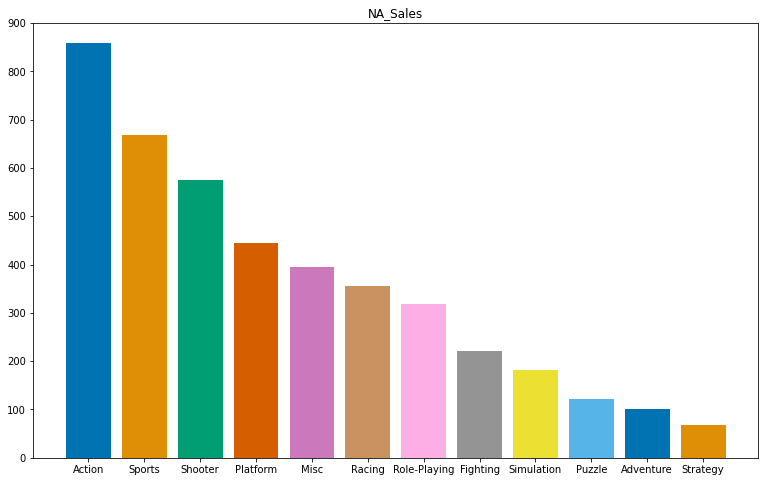

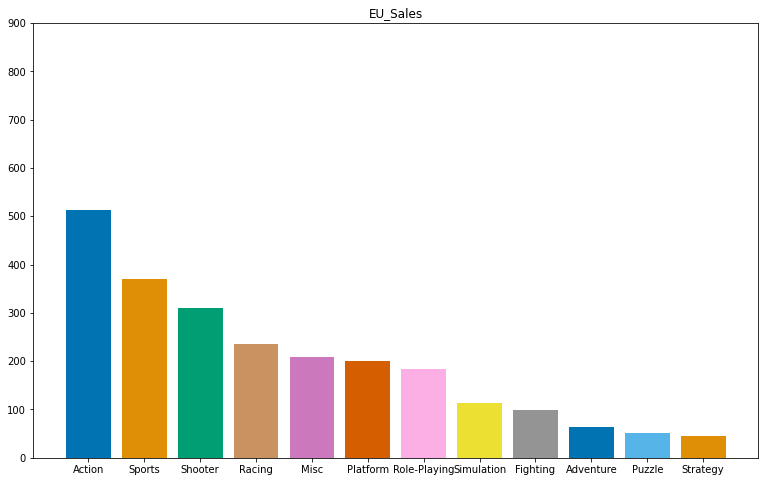

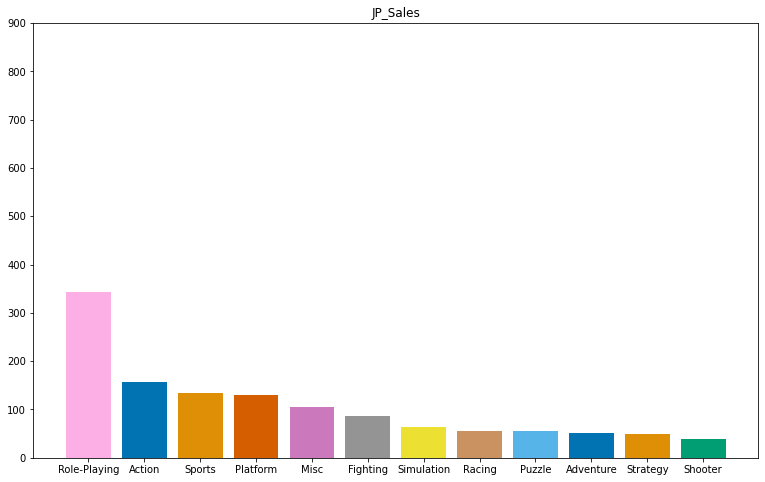

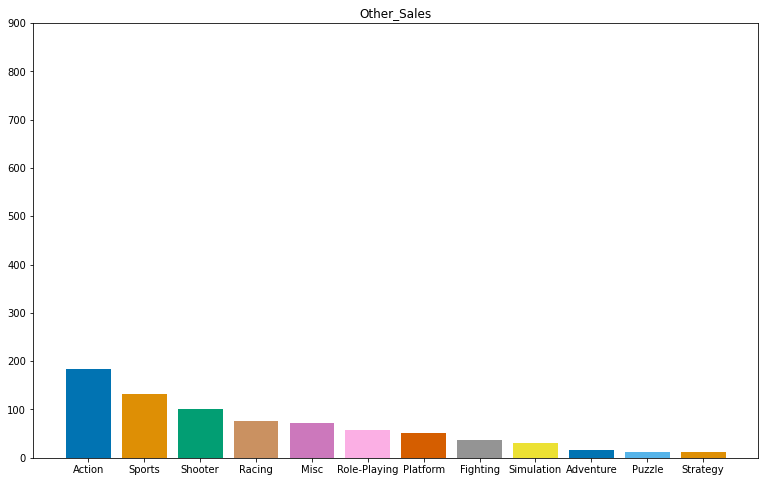

In [229]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import chi2_contingency

obs = dfg.T
chi2,pval1,_,_ = chi2_contingency(obs, correction = False)    ##1위와 2위와의 전체 비율적으로 얼마만큼의 차이가 나는지, 보다 이 장르가 1위이다. 2위이다.
print(pval1)  ## p value <0.05 : 귀무가설을 기각 : => 지역별로 sales 분포가 다르다.

## 그렇다면 판매량의 분포는 다르지만 순위는 비슷하지 않을까. 즉 NA나라의 1위와 2위의 판매량 차이와 EU나라의 1위와 2위 판매량 차이는 서로 다르지만, 1위 2위 순위는 같지 않을까?
## 귀무가설 : 판매 인기(Sales)순위는 대략적으로 비슷할 것이다.
## dfg의 Genre 12개를 1~12로 숫자를 할당해서 분포도 확인.

colors = sns.color_palette('colorblind',len(dfg.index)) ## Genre 색상 지정
dfg_sort = dfg.sort_values(by=dfg.columns[0], ascending=False)
dfg_sort['color'] = colors   ##Genre - color 매칭.

for i in range(len(dfg.columns)):         ## 각 지역별 genre 순위 plot으로 그리기.
  fig, ax = plt.subplots(figsize=(13,8))      ## figsize
  ax.set_title(dfg.columns[i])
  plt.ylim(0,900)
  dfNA = dfg_sort.sort_values(by=dfg.columns[i], ascending=False)     ##dfNA는 지역변수, dfEU, dfJP, dfOther...
  ax.bar(dfNA.index, dfNA[dfg.columns[i]], color=dfNA.color)
## Sales의 총합은 Action이 제일 많을 수도 있으나, game수로 나눌 경우 평균의 판매량은 다를 수 있다.
## 라고 생각했으나, 그냥 인기가 제일 많다.로 단순히 생각하는게 나을듯. 왜냐하면 아직은 판매수익까지 예측하는게 아니니까.

##bottom 위에 쌓아서 합친 bar plot 필요.

In [230]:
##1. 지역에 따라서 선호하는 게임 장르가 다를까 라는 질문에 대답을 하셔야합니다.
##가설 세우고 test, pvalue 검증. (t-test, chi-test, f-test)
##귀무가설 : 지역에 따라서 선호하는 게임 장르는 같을 것이다.
##scaling 후 각 row값들이 일치하는지 확인. 신뢰구간 ~범위내
## -> scaling하면 안됨. 바로 chi-2적용.

## 각 값에 대해서 pvalue, 인기순위에 대해서 pvalue
from scipy import stats

dfg_rank = dfg.copy()
dfg_rank['Sales_Sum'] = dfg_rank.sum(axis=1)

dfg_rank = dfg_rank.sort_values(by=dfg_rank.columns[4], ascending=False)   ##전체 판매순위를 기준으로 순위 매기기.
dfg_rank['total_Rank'] = np.array(range(1,13))
dfg_rank_chi2 = dfg_rank['total_Rank']

dfgg = dfg_rank.copy()
for i in range(4) :
  dfgg = dfgg.sort_values(by=dfgg.columns[i], ascending=False)
  dfgg['rank'] = np.array(range(1,13))      ## 각 나라마다 genre에 순위할당
  dfg_rank = pd.concat([dfg_rank,dfgg['rank']], axis=1 )

dfg_rank

,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Sales_Sum,total_Rank,rank,rank,rank,rank
Action,858.75,513.64,156.60,183.99,1712.98,1,1,1,2,1
Sports,667.26,370.97,134.76,132.35,1305.34,2,2,2,3,2
Shooter,574.48,310.23,38.18,101.86,1024.75,3,3,3,12,3
Role-Playing,318.76,183.09,342.93,56.73,901.51,4,7,7,1,6
Platform,445.38,200.63,130.53,51.45,827.99,5,4,6,4,7
Misc,394.73,208.15,104.18,72.64,779.70,6,5,5,5,5
Racing,354.70,235.02,56.32,76.51,722.55,7,6,4,8,4
Fighting,220.35,99.90,87.14,36.15,443.54,8,8,9,6,8
Simulation,181.43,112.99,63.54,31.32,389.28,9,9,8,7,9
Puzzle,121.58,50.47,56.24,12.44,240.73,10,10,11,9,11


In [231]:
chi2, pval,_,_ = chi2_contingency(dfg_rank.iloc[:,6:10], correction = False)
print(pval)     ## 장르와 인기순위(나라별 판매량은)는 관련이 있다. : 나라마다 장르의 선호도는 비슷한 분포를 띤다. p value=0.93

0.9307531767524367


In [232]:
# from sklearn.preprocessing import StandardScaler
# dfg_scale = StandardScaler().fit_transform(dfg)
# dfg_scale = pd.DataFrame(dfg_scale, index = dfg.index, columns=dfg.columns)      ## array->DF
# dfg_scale

### !! chi2 에서 pvalue가 0.05보다 작다는건 column간 연관이 있다는 것이고, scale안하고 바로 chi2 해야 된다.
# from sklearn.preprocessing import MinMaxScaler    ## MinMaxScale(0~1)적용 후 chi2-test하면 무조건 0.99~1나온다. 즉, 잘못된 방법.
# scaler = MinMaxScaler()
# dfg_MmScale = dfg.copy()
# dfg_MmScale[:] = scaler.fit_transform(dfg_MmScale[:])
# dfg_MmScale
# x = np.array(dfg_MmScale['Other_Sales'])[::-1]
# y = np.array(dfg_MmScale['NA_Sales'])[::-1]
# z = np.array(dfg_MmScale['EU_Sales'])[::-1]
# dfg_MmScale['test'] = x
# dfg_MmScale['test2'] = y
# dfg_MmScale['test3'] = z
# dfg_MmScale

In [233]:

##시간되면 cov, corcoeff도 확인해보기.
# res4 = np.cov(dfg['NA_Sales'],dfg['EU_Sales'])[0,1]
# res4
# res = np.corrcoef(dfg['NA_Sales'],dfg['EU_Sales'])[0,1]
# res

## t-test 정규화한다음 2sample t-test하면 평균비교하는거라 같을;(pvalue=1)일 수밖에 없네
# stats.ttest_ind(dfg_scale['Other_Sales'][:],dfg_scale['test'][:])
# stats.ttest_ind(dfg['NA_Sales'][:],dfg['EU_Sales'][:])

# from stats import f_oneway
# g1 = dfg['NA_Sales']
# g2= dfg['EU_Sales']
# g3 = dfg['test']
# f_oneway(g1, g2, g3)


# dfg_scaleNA = dfg_scale.sort_values(by=dfg_scale.columns[0], ascending=False)
# dfg_scaleNA = dfg_scaleNA[0]

# dfg_scaleEU = dfg_scale.sort_values(by=dfg_scale.columns[1], ascending=False)
# dfg_scaleEU = 
### chi2 검증 기댓값을 plt로 표현하면 좋을 듯.
### https://www.jmp.com/ko_kr/statistics-knowledge-portal/chi-square-test/chi-square-test-of-independence.html

In [234]:
## Year EDA
# print(df.Year.unique())    ## 발표자료에 넣기. ~한 값들이 있더라. 네모로 해서. 전처리가 필요하다 의 근거. (96, 9, 6, 16,,,->19__ or 20__)

def toYear(y) :
  if y < 10 :
    y = str(y)
    y = '200'+y
  elif (y>=10) & (y<50):
    y = str(y)
    y = '20'+y
  elif (y>=50) & (y<1000):
    y = str(y)
    y = '19'+y
  else : y = y
  y=float(y)
  y=int(y)
  return y

df['Year'] = df['Year'].apply(toYear)
# df['Year'].unique()     ## 확인.
df
# dfy = df.groupby('Year')[['NA_Sales','EU_Sales','JP_Sales','Other_Sales']].sum()
# dfy     ## year별로 각나라 전체 sales 추이 line 그래프로.

,Name,Platform,Year,Genre,NA_Sales,EU_Sales,JP_Sales,Other_Sales
1,Candace Kane's Candy Factory,DS,2008,Action,0.04,0.00,0.00,0.00
2,The Munchables,Wii,2009,Action,0.17,0.00,0.00,0.01
3,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010,Adventure,0.00,0.00,0.02,0.00
4,Deal or No Deal: Special Edition,DS,2010,Misc,0.04,0.00,0.00,0.00
5,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010,Platform,0.12,0.09,0.00,0.04
...,...,...,...,...,...,...,...,...
16594,Ice Age 2: The Meltdown,GC,2006,Platform,0.15,0.04,0.00,0.01
16595,Rainbow Islands: Revolution,PSP,2005,Action,0.01,0.00,0.00,0.00
16596,NBA 2K16,PS3,2015,Sports,0.44,0.19,0.03,0.13
16597,Toukiden: The Age of Demons,PSV,2013,Action,0.05,0.05,0.25,0.03


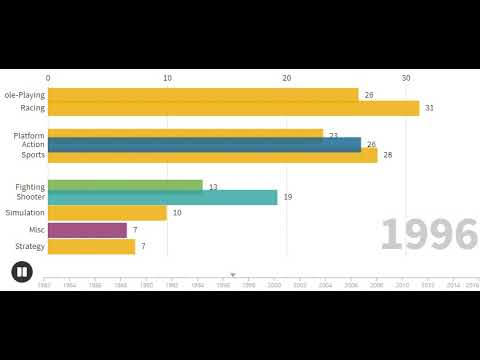

In [235]:
##2. 연도별 게임의 트렌드가 있을까 라는 질문에 대답을 하셔야합니다. ##각나라에서 & 전체.

### barh plt
# for i in range(df['Year'].min(axis=0),2000):     ##, df['Year'].max(axis=0)
#   mask = df['Year']==i
#   dfy = df[mask].groupby('Genre')[['NA_Sales','EU_Sales','JP_Sales','Other_Sales']].sum()
#   dfy['ThisYear'] = dfy.sum(axis=1)

#   dfy = dfy.merge(dfg_sort['color'], how='inner', on='Genre')     ## 전에 만들어놓은 color 가져다 쓰기.
#   dfy = dfy.sort_values(by=dfy.columns[4], ascending=True)    ## dfy.columns[4] = ThisYear
#   fig, ax = plt.subplots(figsize=(13,8))      ## figsize
#   ax.set_title(i)
#   bars = ax.barh(dfy.index, dfy['ThisYear'], color=dfy.color)    ## bar 끝부분에 Genre랑 값 넣기.

#   for bar in bars:      ## barh Text넣기.
#     width = bar.get_width()
#     label_y_pos = bar.get_y() + bar.get_height() / 2
#     ax.text(width, label_y_pos, s=width.round(2), va='center')
#   ##보조선
#   ax.set_axisbelow(True)
#   ax.xaxis.grid(True, color='gray', linestyle='dashed', linewidth=0.5)

#유튜브 영상
from IPython.display import YouTubeVideo, display 
video = YouTubeVideo("NHrhCTz_yV8", width=500) 
display(video)

In [236]:
##동영상으로. github 코드이용.
dfy_yearly=df.copy()
# dfy_yearly = dfy_yearly.set_index(df['Name'])
dff = dfy_yearly.iloc[:,4:8]
dfy_yearly['Sales_Sum'] = dff.sum(axis=1)

dfy_yearly = dfy_yearly[['Year','Genre', 'Sales_Sum']]
dfy_yearly
dfy_yearly=pd.pivot_table(dfy_yearly, index='Year', columns='Genre', values='Sales_Sum',aggfunc = 'sum')
dfy_yearly

## 2017~2020 데이터 부재로 인해 삭제. 나머지 결측치->0
dfy_yearly = dfy_yearly.fillna('0')
dfy_yearly = dfy_yearly.drop(index=[2017,2020], axis=0)

dfy_yearly = dfy_yearly.apply(pd.to_numeric)
# dfy_yearly = dfy_yearly.astype(float)
dfy_yearly = dfy_yearly.T
# dfy_yearly.to_csv('dfy_yearly.csv')
####

# chi2_contingency(dfy_yearly, correction = False)      ## chi2 의 pvalue=0 < 0.05 이므로 관련 없다.
## but 가장 sales많은 몇년걸로 보면 관련 있지 않을까? TOP5이런식으로. or 각 장르별 연도별 graph(장르중첩시켜서.)
## 최근 몇년걸로 넣어야할듯(트렌드 보기위해서.) or cov +갯수 > -갯수 이런식으로 해도. 

In [237]:
### Year line plot
# dfy_yearly

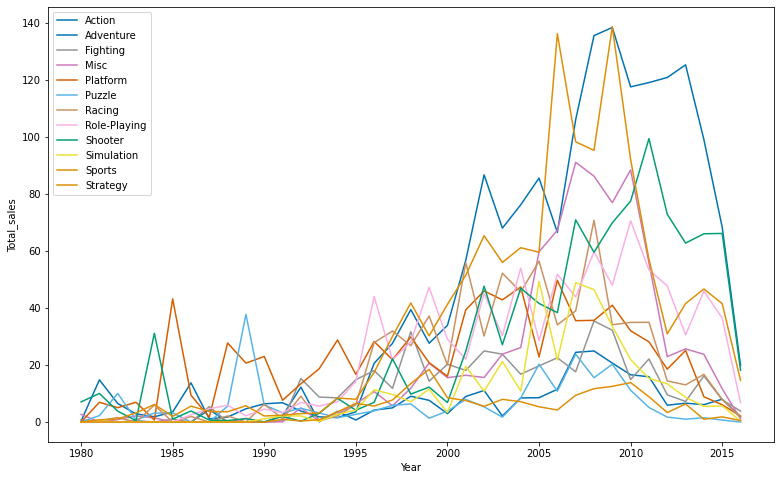

In [238]:
##colorDF만들어서 Genre별 color지정(위와 동일한 color)
dfg_sort['color'] = colors   ##Genre - color 매칭.
dfg_color = dfg_sort[['color']]
dfy_colorr=pd.concat([dfy_yearly, dfg_color],axis=1)

## 장르의 연도별 line plot
fig, ax = plt.subplots(figsize=(13,8))
plt.ylabel('Total_sales')
plt.xlabel('Year')
for i in range(len(dfy_yearly.T.columns)) :
  x = dfy_yearly.T.index
  y = dfy_yearly.T.iloc[:,i]
  ax.plot(x,y, color = dfy_colorr['color'][i], label=dfy_yearly.index[i])   ##판매량을 그래프로, & %를 그래프로. (급 뜨는 게임장르가 있을 수도. or format- starting point o표시)
  ax.legend()

## -> data analytics가 필요한 이유. : 그래프 봐도 모른다;; yeah, that looks right..?

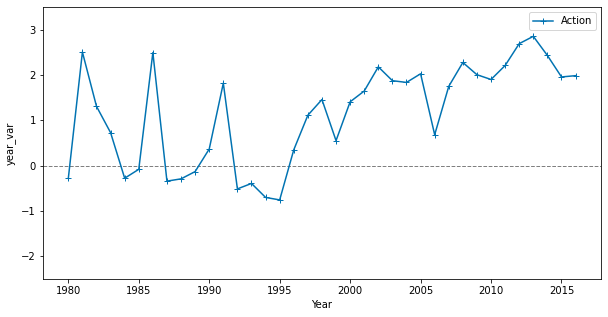

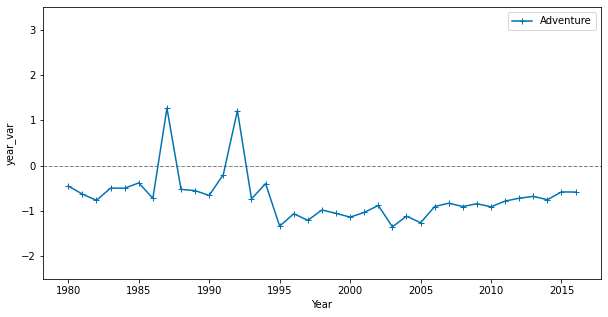

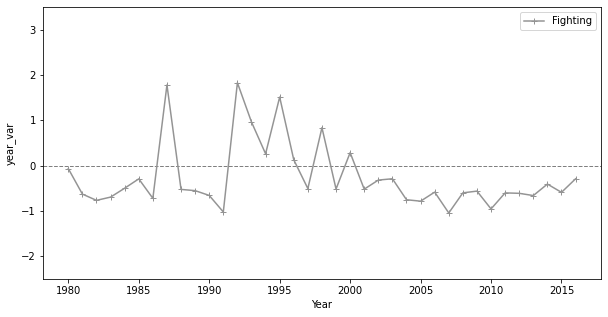

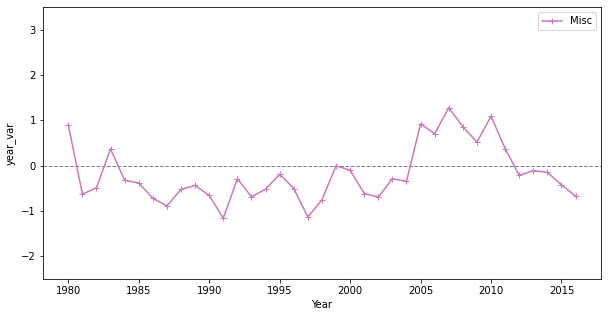

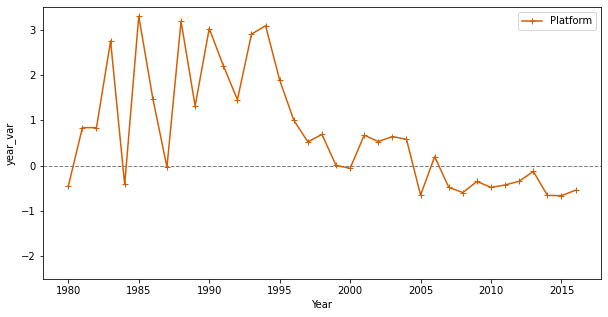

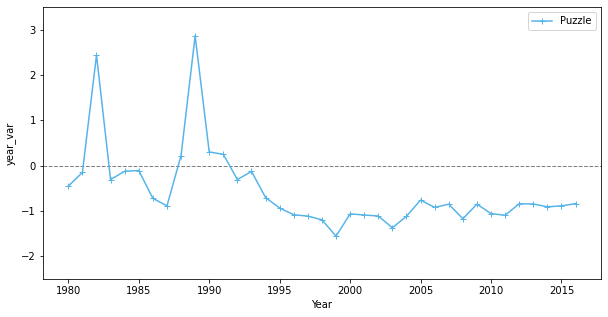

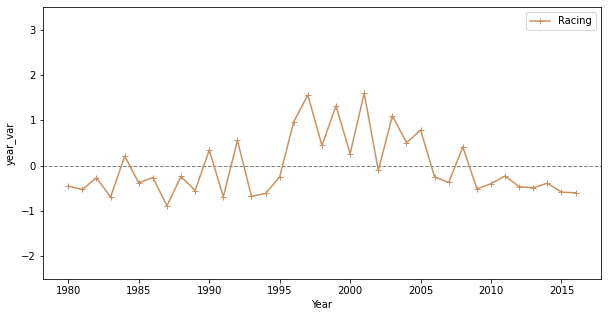

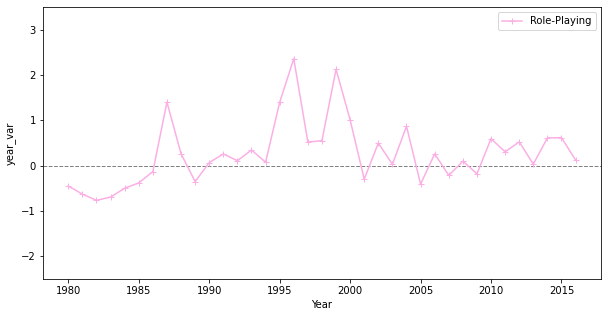

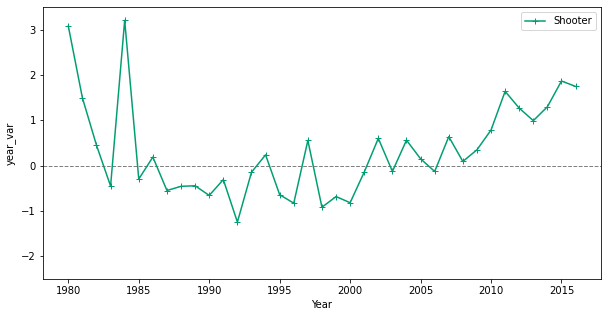

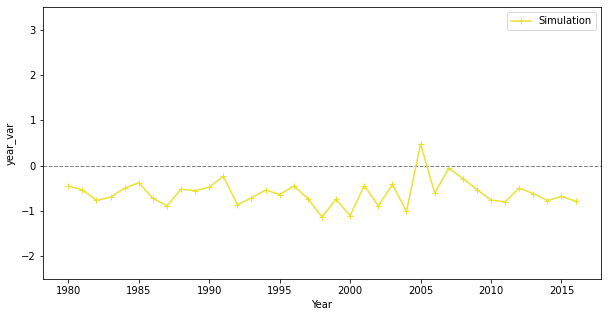

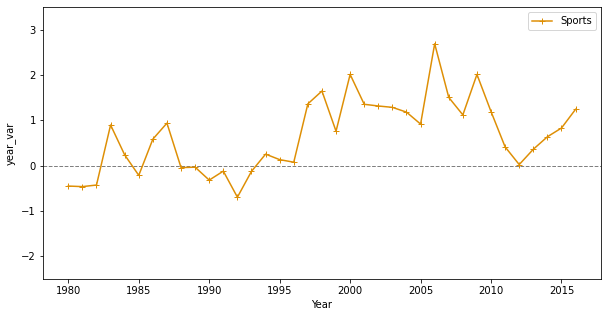

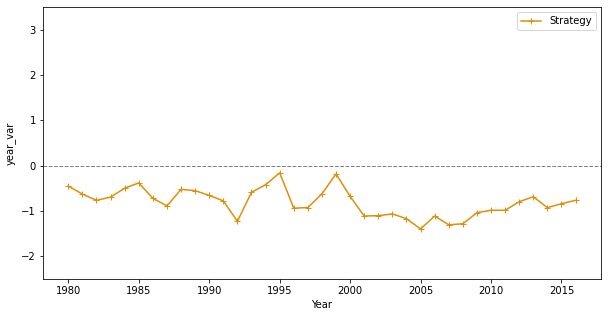

In [239]:
## 가설 : 2010~2015년 사이의 data양이 부족해서 그래프가 전체적으로 하향곡선을 띤다.
## or 경기가 안 좋아서 or 게임산업이 지는 트렌드다 등등 ## 
## but 우리가 알고 싶은건 게임산업 내에서의 장르or플랫폼의 트렌드 동향을 알고 싶은거.& 평균으로부터의 거리정도는 비슷할 듯. 하나가 감소할 때 하나가 증가하는 게 있는지.  
from sklearn.preprocessing import StandardScaler

dfy_scale = StandardScaler().fit_transform(dfy_yearly)
dfy_scale = pd.DataFrame(dfy_scale, index = dfy_yearly.index, columns=dfy_yearly.columns)      ## array->DF

for i in range(len(dfy_scale.index)) :
  fig, ax = plt.subplots(figsize=(10,5))
  plt.ylim(-2.5,3.5)
  plt.ylabel('year_var')
  plt.xlabel('Year')
# for i in range(len(dfy_scale.index)) :  ##한번에 보기.

  ax.axhline(y = 0, color='grey', linewidth=1, linestyle = '--')    ## y=0 기준선
  x = dfy_scale.T.index
  y = dfy_scale.T.iloc[:,i]
  # ax.plot(x,y, color = dfy_colorr['color'][i], label=dfy_yearly.index[i])
  ax.plot(x,y, color = dfy_colorr['color'][i], label=dfy_scale.index[i], marker='+')
  ax.legend()

## Year별 트렌드 : Action,Shooter,Sports가 최근 트렌드, but 3개에 대한 검증 필요.+Platform (시간 없으면 그냥 전체 출고량이 높은 걸로)
## Platform은 따로 생각하면 과정 그대로 밟으면 되는데, Platform과 Genre를 2개의 매개변수로 생각하면...?) => PCA. 가중치와의 관계적용해서 가장 좋은 (Platform-Genre)선택

In [240]:
# ## 출고량이 제일 높은 게임에 대한 분석  ##1. genre, 2.platform
# dfg['sum'] = dfg.sum(axis=1)
# dfg = dfg.sort_values(by='sum', ascending=False)
# dfg     ##전체 출고량을 보면 Action > Sports > Shooter가 인기 있다. (%, 분산에 따라..?)

In [241]:
##Genre, platfrom crosstable
dfc = df.copy()
dff = df.iloc[:,4:8]
dfc['total_Sales'] = dff.sum(axis=1)

dfc=pd.pivot_table(dfc, index='Genre', columns='Platform', values='total_Sales',aggfunc = 'sum')
dfc = dfc.fillna('0')     ## 결측치를 0으로 하면 : 출시했는데 안팔린걸로 될텐데;;-> ㄴㄴ 19xx~2015통틀어서 게임자체가 아예 없다는건 그냥 출시했는데 안팔렸다로 봐도 됨.or시장성이없다. (or 중간값으로 처리하는방법도 알아봐야..)
dfc = dfc.apply(pd.to_numeric)
dfc   ## sns. heatmap 으로 만들기.

Platform,2600,3DO,3DS,DC,DS,GB,GBA,GC,GEN,GG,N64,NES,NG,PC,PCFX,PS,PS2,PS3,PS4,PSP,PSV,SAT,SCD,SNES,TG16,WS,Wii,WiiU,X360,XB,XOne
Genre,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Action,26.31,0.00,56.49,1.26,113.99,7.93,54.13,37.11,2.74,0.00,29.31,28.75,0.00,29.66,0.00,125.59,269.68,301.49,84.70,62.68,19.98,0.65,0.00,10.08,0.00,0.00,110.32,19.31,239.60,47.44,33.78
Adventure,0.40,0.06,4.74,2.50,47.11,17.15,11.87,5.93,0.19,0.00,0.45,4.38,0.00,10.03,0.00,20.71,21.22,22.85,4.70,10.68,4.10,4.16,0.00,1.50,0.14,0.00,18.26,0.19,15.19,3.02,2.49
Fighting,0.77,0.00,10.44,1.83,7.20,0.00,4.16,18.43,5.89,0.00,22.11,6.54,1.42,0.14,0.00,72.74,89.20,51.71,8.04,21.89,3.18,8.53,0.00,26.94,0.00,0.00,23.81,6.34,37.09,12.80,2.34
Misc,3.57,0.00,10.47,0.00,137.52,13.35,28.38,16.44,0.03,0.00,11.14,3.59,0.00,8.40,0.00,44.88,98.02,45.82,7.37,13.68,5.20,1.20,0.09,5.02,0.00,0.00,208.51,12.21,89.36,8.57,6.88
Platform,13.26,0.00,32.25,2.53,77.34,53.88,77.99,28.59,15.44,0.04,36.10,95.78,0.00,0.47,0.00,64.22,72.13,29.74,6.99,16.56,3.01,0.76,1.50,65.65,0.00,0.00,90.70,21.26,11.37,9.63,0.80
Puzzle,13.67,0.02,5.55,0.00,83.39,47.47,11.99,3.85,0.00,0.00,3.39,20.99,0.00,0.93,0.00,12.06,5.94,0.45,0.02,5.42,0.20,1.00,0.00,6.38,0.00,0.00,15.53,1.34,0.73,0.41,0.00
Racing,2.32,0.00,14.43,2.65,38.54,4.55,18.81,21.77,0.26,0.00,38.91,9.78,0.00,3.78,0.00,102.49,154.33,73.09,11.57,34.71,2.94,2.40,0.07,13.49,0.00,0.00,61.10,7.78,64.91,29.04,8.83
Role-Playing,0.00,0.00,61.34,0.68,126.49,88.24,64.15,13.04,0.27,0.00,3.02,18.78,0.00,47.22,0.03,76.55,85.66,75.32,25.78,48.92,13.08,3.76,0.06,36.45,0.00,1.22,14.08,2.44,71.96,13.51,9.46
Shooter,22.96,0.00,1.23,0.33,8.10,1.19,3.56,13.61,0.13,0.00,19.26,35.62,0.00,43.33,0.00,39.33,108.20,195.79,75.32,19.80,4.59,3.97,0.00,6.06,0.02,0.00,26.16,6.16,277.14,61.30,51.59


In [242]:
from sklearn.preprocessing import StandardScaler    ## PC1,2 만들려면 일단 platform과 장르에 연관성이 있다.(platform마다 장르의 선호도는 동일하다)는 전제를 먼저 검정해야하고,
##검정된다 하더라도 column수와 PCA수가 일치하지 않기 때문에 PCA축의 값이 클 수록 판매량이 크다는 가설도 증명해주지 못함. 게다가 PC1+PC2의 값으로 판단하는 건지 확신도 안서고.
##즉, 그냥 heatmap 으로.
dfc_scale = StandardScaler().fit_transform(dfc)
dfc_scale = pd.DataFrame(dfc_scale, index = dfc.index, columns=dfc.columns)      ## array->DF
from sklearn.decomposition import PCA

pca = PCA(n_components=2) ## n 더늘어나도 PC1, PC2, ...는 안바뀜. 

principalComponents = pca.fit_transform(dfc)    ## numerical feature(4개)에서 pca(2개)찾기.
principalDf = pd.DataFrame(data = principalComponents
              , columns = ['PC1', 'PC2'], index = dfc.index)     ## 분산이 가장 큰 PC1와 가장 작은 PC2
principalDf

,PC1,PC2
Genre,,
Action,331.110855,61.574220
Adventure,-139.632781,25.325853
Fighting,-62.276803,20.150212
Misc,18.986727,-122.659478
Platform,-71.287699,-62.915445
Puzzle,-171.304384,11.725992
Racing,19.566666,-13.540891
Role-Playing,-30.775602,37.240313
Shooter,162.199217,176.446766


In [243]:
pc_var = principalDf.var()   ## largest eigenvector(PC1)의 variance, smallest eigenvector(PC2)의 variance
pc_var

PC1    26397.480864
PC2     7729.491963
dtype: float64

In [244]:
ratio = pca.explained_variance_ratio_
ratio

array([0.62508339, 0.18303175])

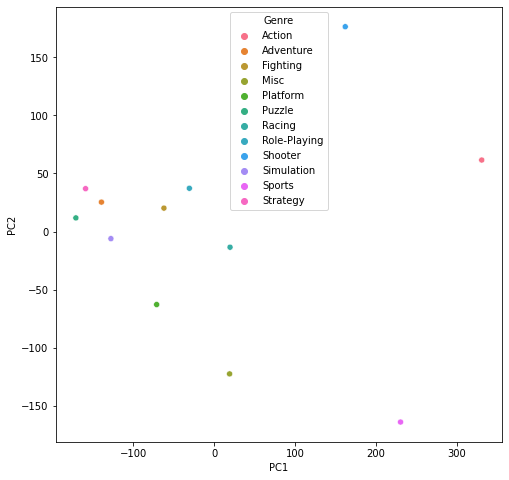

In [245]:
plt.subplots(figsize=(8,8))
sns.scatterplot(data=principalDf,x='PC1',y='PC2',hue='Genre')     ## platform에 대해서 장르 순위가 동일한지. 에 대한 검정 필요.

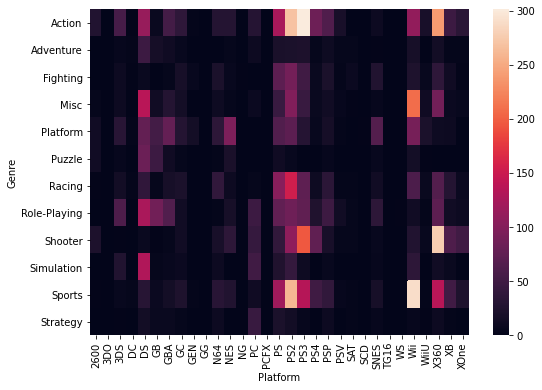

In [246]:
import seaborn as sns
fig, ax = plt.subplots(figsize = (8.5,6))
ax = sns.heatmap(dfc)     ## (Action, PS3) , Actioin이 트렌드. 따라서 PS3 플랫폼 형태의 Action 게임을 만든다., Action Genre의 판매량(분산)이 높은 NA, EU 지역 중심으로 마케팅.

In [247]:
# ## 역대 가장 인기 있는 game
dfs['sum'] = dfs.sum(axis=1)

df2 = pd.concat([df1,dfs],axis=1)    ## df1 : sales제외한 df의 앞 column부분,   dfs : df의 sales부분
df2 = df2.sort_values(by='sum' ,ascending=False)      ##intro로 이렇게 격차가 크다(출시게임을 설계하는게 중요하다 & 관심끌기)는 걸 보여주면 좋을듯.(++ 특정지역에서만 성공? or 한지역에서의 성공이 다른 지역에서도 성공을 보장하는지. 관련성파악하기.)
df2[0:10]

,Name,Platform,Year,Genre,NA_Sales,EU_Sales,JP_Sales,Other_Sales,sum
2909,Wii Sports,Wii,2006.0,Sports,41.49,29.02,3.77,8.46,82.74
4200,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,40.24
12580,Mario Kart Wii,Wii,2008.0,Racing,15.85,12.88,3.79,3.31,35.83
3353,Wii Sports Resort,Wii,2009.0,Sports,15.75,11.01,3.28,2.96,33.00
7830,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,31.38
1204,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,30.26
6938,New Super Mario Bros.,DS,2006.0,Platform,11.38,9.23,6.50,2.90,30.01
3015,Wii Play,Wii,2006.0,Misc,14.03,9.20,2.93,2.85,29.01
16532,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.59,7.06,4.70,2.26,28.61
10489,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,28.31


In [248]:
## but sum 을 게임 수로 나누면 예상 Sales값은 다를 수 있다. & 인기순위가 높을수록 경쟁사 또한 많기 때문에 그것에 대한 분석도 필요.
